In [1]:
import torch, shap, glob, os
import numpy as np, pandas as pd, torchvision.transforms as transforms
import random

from Bio import SeqIO
from tqdm.notebook import tqdm
from torch.nn import Module
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from torchvision.models import  resnet18, alexnet

np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

In [4]:
save_weight_path ='./models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.31[NATCG]_200px/'
# save_weight_path = './models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/'

weights_name = "weights_Multiclass_Covid19(Non-kmer3)[NACGT].2022.04.01.pt"
# weights_name = "weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt"

path2weights = os.path.join(save_weight_path,weights_name)

In [5]:
# npy_path = './np_image_totalunit/multiclass_totalunit/'
npy_path = './np_image_totalunit/multiclass_nactg_200px/'

In [6]:
npy_data_list = [os.path.join(npy_path,'image_npy',i ) for i in sorted(os.listdir(os.path.join(npy_path,'image_npy')))]
label_ = np.load(os.path.join(npy_path,'label.npy'))

In [7]:
nas_path = "./dataset_1401/"
lineage_label = pd.read_csv('./dataset_1401/1404_lineage_report and metadata 20220316.csv')[['scorpio_call_y','diff']]
lineage_label = np.array(lineage_label.fillna("None"))
label_s = []
name_ = []
new_lineage_label = []
for idx, rna in enumerate(SeqIO.parse('./dataset_1401/1404.sequences.aln.fasta',"fasta")):
    # print(lineage_label[idx][0].split(' ')[0])
    label_s.append(lineage_label[idx][0].split(' ')[0])
    name_.append(lineage_label[idx][0])
    new_lineage_label.append(str(rna.seq).replace('-','N'))

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npy_data_list, label_,stratify = label_, test_size=0.25, random_state=42)

print(len(X_train), len(y_train)) 

print(len(X_test), len(y_test))

1053 1053
351 351


In [9]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class TransferDataset(Dataset):
    def __init__(self, s_path, labels, transform):
        self.transform = transform
        self.s_path = s_path
        self.labels = labels
        
    def __len__(self):
        return len(self.s_path)

    def __getitem__(self, idx):
        singel_image_ = np.load(self.s_path[idx]).astype(np.float32)
        seed = np.random.randint(1e9)       
        random.seed(seed)
        np.random.seed(seed)
        singel_image_ = self.transform(singel_image_)
        label = int(self.labels[idx])
        # print(label)

        return singel_image_, label

In [10]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean, std),
            ])     

train_ds = TransferDataset(s_path= X_train, labels= y_train, transform= transformer)
test_ds = TransferDataset(s_path= X_test, labels= y_test, transform= transformer)
print(len(train_ds), len(test_ds))

1053 351


In [11]:
imgs, label = train_ds[10]
batch_size = 32
train_dl = DataLoader(train_ds, batch_size= batch_size, 
                        shuffle=True)
test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                        shuffle=False)  

In [12]:
# eval
def reload_model():
    models = alexnet(pretrained=False, num_classes=max(label_)+1).to(device)

    
    checkpoint = torch.load(path2weights, map_location=torch.device('cpu'))
    # checkpoint = torch.load('./models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt', map_location=torch.device('cpu'))
    models.load_state_dict(checkpoint['model_state_dict'])
    return models

In [13]:
test_dl = DataLoader(test_ds, batch_size= 1, 
                        shuffle=False) 
images, label =next(iter(test_dl))
print(images.shape, label)

torch.Size([1, 3, 200, 200]) tensor([3])


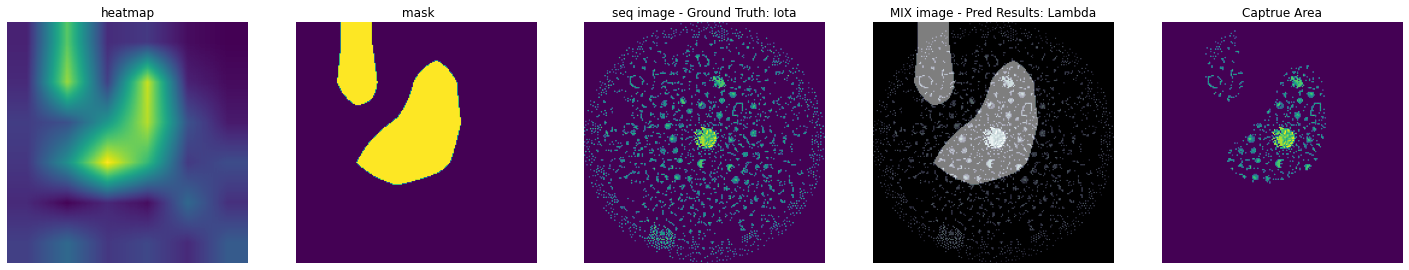

In [26]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp, LayerCAM 
from torchcam.utils import overlay_mask
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_dict = {0:'Alpha', 1:'B.1.1.318-like', 2:'Beta', 3:'Delta', 4:'Eta', 5:'Gamma', 6:'Iota', 7:'Lambda', 8:'Mu', 9:'None'}
def loader_cam(image_, lable_): #single classes loader
    model = reload_model()
    cam_extractor = LayerCAM(model)
    classes__ = class_dict[int(lable_)]
    out = model(image_.to(device))
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)
    
    cam_extractor.clear_hooks()
    
    # Resize it
    resized_cams = [resize(to_pil_image(cam), img.shape[-2:]) for cam in cams]
    segmaps = [to_pil_image((resize(cam.unsqueeze(0), img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]

    # Plot it

    # 
    for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
        _, axes = plt.subplots(1, 5, figsize=(25, 7))
        axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(f'heatmap')
        axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(f' mask')
        axes[2].imshow(images[0][0]); axes[2].axis('off'); axes[2].set_title(f'seq image - Ground Truth: {classes__}')
        axes[3].imshow(images[0][0], cmap='bone')
        axes[3].imshow(seg, alpha=0.5, cmap='bone'); axes[3].axis('off'); axes[3].set_title(f'MIX image - Pred Results: {class_dict[torch.argmax(out).item()]}')

        capture_image = np.where(np.array(seg), np.array(images[0][0]), np.array(images[0][0])*0)
        axes[4].imshow(capture_image); axes[4].axis('off'); axes[4].set_title(f'Captrue Area')
        plt.show()


for img, lab in test_dl:
    if int(lab)==6:
        images = img
        label = lab
        loader_cam(images, label)
        # break